In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import BayesianRidge
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance


# Generate Data

In [2]:
# set random seed
np.random.seed(5)

# Number of samples
num_samples = 10000

# Numerical features
data = pd.DataFrame({
    'Age': np.random.randint(18, 80, num_samples),
    'Annual Income': np.random.randint(17000, 200000, num_samples),
    'Credit Score': np.random.randint(300, 850, num_samples),
    'Number of Dependents': np.random.randint(0, 5, num_samples),
    'Years at Current Address': np.random.randint(0, 40, num_samples),
    'Claim Amount (last year)': np.random.randint(0, 50000, num_samples),
    'Number of Claims (last 5 years)': np.random.randint(0, 10, num_samples),
    'Vehicle Age': np.random.randint(0, 20, num_samples),
    'Property Value': np.random.randint(50000, 1000000, num_samples),
    'Loan Amount': np.random.randint(0, 500000, num_samples),
    'Monthly Premium': np.random.randint(50, 1000, num_samples),
    'Policy Tenure': np.random.randint(0, 30, num_samples),
    'Number of Policies Held': np.random.randint(1, 5, num_samples)
})

# Categorical features
data['Gender'] = np.random.choice(['Male', 'Female', 'Other'], num_samples)
data['Marital Status'] = np.random.choice(['Single', 'Married', 'Divorced', 'Widowed'], num_samples)
data['Education Level'] = np.random.choice(['High School', 'Associate Degree', 'Bachelor Degree', 'Master Degree', 'Doctorate'], num_samples)
data['Occupation'] = np.random.choice(['Engineer', 'Doctor', 'Teacher', 'Lawyer', 'Artist', 'Scientist', 'Salesperson', 'Clerk'], num_samples)
data['Employment Type'] = np.random.choice(['Salaried', 'Self-employed'], num_samples)
data['Vehicle Type'] = np.random.choice(['Sedan', 'SUV', 'Truck'], num_samples)
data['Vehicle Make'] = np.random.choice(['Toyota', 'Ford', 'Chevrolet', 'Honda', 'BMW'], num_samples)
data['Vehicle Model'] = np.random.choice(['Model A', 'Model B', 'Model C', 'Model D', 'Model E'], num_samples)
data['Home Type'] = np.random.choice(['flat', 'House'], num_samples)
data['Payment Method'] = np.random.choice(['Credit Card', 'Bank Transfer'], num_samples)
data['Region or State'] = np.random.choice(['Region A', 'Region B', 'Region C', 'Region D'], num_samples)
data['Communication Preference'] = np.random.choice(['Email', 'Phone'], num_samples)
data['Customer Segment'] = np.random.choice(['High Value', 'Standard'], num_samples)

# Ordinal features
data['Health Status'] = np.random.choice(['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'], num_samples)
data['Driving Record'] = np.random.choice(['Bad', 'Average', 'Good'], num_samples)
data['Home Ownership'] = np.random.choice(['Rent', 'Mortgage', 'Own'], num_samples)
data['Customer Satisfaction'] = np.random.randint(1, 6, num_samples)
data['Policy Renewal Likelihood'] = np.random.choice(['Unlikely', 'Likely', 'Very Likely'], num_samples)
data['Claim Severity'] = np.random.choice(['Minor', 'Moderate', 'Major'], num_samples)
data['Insurance Literacy'] = np.random.choice(['Low', 'Medium', 'High'], num_samples)
data['Loyalty Tier'] = np.random.choice(['Bronze', 'Silver', 'Gold', 'Platinum'], num_samples)



# not all of these features are going to be relevant 


In [3]:
# add missing values (1% per column)
for col in data.columns:
    data.loc[data.sample(frac=0.01).index, col] = np.nan


# add label column of 'claim status' binary
data['claim status'] = np.random.choice([0,1], num_samples)

# add duplicates (1% of the data)
data = pd.concat([data, data.sample(frac=0.01)], ignore_index=True)

data.head()

,Age,Annual Income,Credit Score,Number of Dependents,Years at Current Address,Claim Amount (last year),Number of Claims (last 5 years),Vehicle Age,Property Value,Loan Amount,...,Customer Segment,Health Status,Driving Record,Home Ownership,Customer Satisfaction,Policy Renewal Likelihood,Claim Severity,Insurance Literacy,Loyalty Tier,claim status
0,53.0,134116.0,642.0,3.0,0.0,44189.0,4.0,2.0,418483.0,123919.0,...,Standard,Poor,Average,Own,5.0,Unlikely,Major,High,Silver,1
1,32.0,80351.0,461.0,4.0,8.0,32989.0,8.0,10.0,930909.0,357208.0,...,Standard,Good,Good,Mortgage,2.0,Unlikely,Minor,Medium,Gold,1
2,65.0,175440.0,777.0,3.0,33.0,36874.0,9.0,10.0,266823.0,133234.0,...,High Value,Excellent,Average,Own,5.0,Unlikely,Minor,Medium,Platinum,1
3,79.0,120601.0,682.0,2.0,32.0,17849.0,6.0,12.0,384854.0,184732.0,...,NaN,Good,Good,Rent,2.0,Likely,Moderate,High,Silver,0
4,56.0,28789.0,440.0,2.0,20.0,14600.0,6.0,17.0,998836.0,57861.0,...,Standard,Good,Good,Rent,3.0,Very Likely,Major,Low,Platinum,1


# pre process data;
- drop duplicates
- impute missing values; unsure if this would be done this would have to be a combination of 
    - seeing how often nan values occur, 
    - which features are used in training the model (not all features are going to be of high feature importance, want as simple as model as possible to reduce overfitting) 
    - model accuracy when using impute vs dropping (e.g do you want to impute salary if salary is the biggest predictor of claim status)

In [4]:
data_deduped=data.drop_duplicates()
data_deduped.shape,data.shape

((10000, 35), (10100, 35))

# going to use iterative imputer because;
-   it captures inter feature relationships better than just taking the average e.g profression and salary are going to be closely related. 
-  the BayesianRidge estimator used in the imputation is simple and can model the complex relationships in the dataset without overfitting. as I created the dataset I  have prior knowledge of the distibrution which is normally distributed  good for simple models.

In [5]:
# nan values should be 100; 1% of 10,000
data_deduped.isna().sum()

Age                                100
Annual Income                      100
Credit Score                       100
Number of Dependents               100
Years at Current Address           100
Claim Amount (last year)           100
Number of Claims (last 5 years)    100
Vehicle Age                        100
Property Value                     100
Loan Amount                        100
Monthly Premium                    100
Policy Tenure                      100
Number of Policies Held            100
Gender                             100
Marital Status                     100
Education Level                    100
Occupation                         100
Employment Type                    100
Vehicle Type                       100
Vehicle Make                       100
Vehicle Model                      100
Home Type                          100
Payment Method                     100
Region or State                    100
Communication Preference           100
Customer Segment         

In [6]:


# use default bayseian imputer
imputer = IterativeImputer(estimator=BayesianRidge,random_state=5)


data_=data_deduped.copy()
print(data_.select_dtypes(include=['object']).columns)


# Encode categorical features
label_encoders = {}
for col in data_.select_dtypes(include='object').columns:
    le = LabelEncoder()
    # Only fit label encoder on non-null values
    non_null = data_[col].dropna().astype(str)
    le.fit(non_null)
    data_[col] = data_[col].astype(str).apply(lambda x: x if x != 'nan' else np.nan)
    data_[col] = data_[col].map(lambda x: le.transform([x])[0] if pd.notnull(x) else np.nan)
    label_encoders[col] = le

# Apply Iterative Imputer
imputer = IterativeImputer(random_state=5)
data_imputed = pd.DataFrame(imputer.fit_transform(data_), columns=data_.columns)

# change back to categoical dataset for further analysis, keep the label encoded version as that will be fed into the model
data_imputed_back_to_categorical = data_imputed.copy()
# Decode categorical features back to original labels
for col in label_encoders:
    le = label_encoders[col]
    data_imputed_back_to_categorical[col] = data_imputed_back_to_categorical[col].round().astype(int)
    data_imputed_back_to_categorical[col] = le.inverse_transform(data_imputed_back_to_categorical[col])

data_imputed_back_to_categorical


Index(['Gender', 'Marital Status', 'Education Level', 'Occupation',
       'Employment Type', 'Vehicle Type', 'Vehicle Make', 'Vehicle Model',
       'Home Type', 'Payment Method', 'Region or State',
       'Communication Preference', 'Customer Segment', 'Health Status',
       'Driving Record', 'Home Ownership', 'Policy Renewal Likelihood',
       'Claim Severity', 'Insurance Literacy', 'Loyalty Tier'],
      dtype='object')


,Age,Annual Income,Credit Score,Number of Dependents,Years at Current Address,Claim Amount (last year),Number of Claims (last 5 years),Vehicle Age,Property Value,Loan Amount,...,Customer Segment,Health Status,Driving Record,Home Ownership,Customer Satisfaction,Policy Renewal Likelihood,Claim Severity,Insurance Literacy,Loyalty Tier,claim status
0,53.0,134116.0,642.0,3.0,0.0,44189.0,4.0,2.0,418483.0,123919.0,...,Standard,Poor,Average,Own,5.0,Unlikely,Major,High,Silver,1.0
1,32.0,80351.0,461.0,4.0,8.0,32989.0,8.0,10.0,930909.0,357208.0,...,Standard,Good,Good,Mortgage,2.0,Unlikely,Minor,Medium,Gold,1.0
2,65.0,175440.0,777.0,3.0,33.0,36874.0,9.0,10.0,266823.0,133234.0,...,High Value,Excellent,Average,Own,5.0,Unlikely,Minor,Medium,Platinum,1.0
3,79.0,120601.0,682.0,2.0,32.0,17849.0,6.0,12.0,384854.0,184732.0,...,Standard,Good,Good,Rent,2.0,Likely,Moderate,High,Silver,0.0
4,56.0,28789.0,440.0,2.0,20.0,14600.0,6.0,17.0,998836.0,57861.0,...,Standard,Good,Good,Rent,3.0,Very Likely,Major,Low,Platinum,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,31.0,20454.0,537.0,1.0,35.0,35224.0,7.0,12.0,463865.0,53260.0,...,Standard,Very Good,Average,Mortgage,3.0,Unlikely,Minor,Medium,Silver,0.0
9996,38.0,143481.0,479.0,1.0,37.0,15045.0,7.0,5.0,616002.0,349599.0,...,Standard,Good,Good,Mortgage,1.0,Very Likely,Moderate,Medium,Gold,0.0
9997,66.0,99387.0,650.0,3.0,19.0,28106.0,1.0,5.0,543184.0,4423.0,...,Standard,Excellent,Bad,Mortgage,3.0,Very Likely,Minor,Medium,Bronze,0.0
9998,47.0,151198.0,374.0,3.0,22.0,26065.0,6.0,1.0,853451.0,103172.0,...,Standard,Very Good,Bad,Rent,5.0,Unlikely,Moderate,Low,Silver,0.0


In [7]:
# check example to see if imputation has worked
print(data.loc[9997])
print(data_imputed_back_to_categorical.loc[9997])

Age                                       66.0
Annual Income                          99387.0
Credit Score                             650.0
Number of Dependents                       3.0
Years at Current Address                  19.0
Claim Amount (last year)               28106.0
Number of Claims (last 5 years)            1.0
Vehicle Age                                5.0
Property Value                        543184.0
Loan Amount                             4423.0
Monthly Premium                          668.0
Policy Tenure                             26.0
Number of Policies Held                    4.0
Gender                                   Other
Marital Status                         Married
Education Level                      Doctorate
Occupation                           Scientist
Employment Type                       Salaried
Vehicle Type                             Truck
Vehicle Make                               BMW
Vehicle Model                          Model A
Home Type    

In [8]:
# check to make sure the data disritbution and limits are the same as when they were generated
data_imputed_back_to_categorical.describe()

,Age,Annual Income,Credit Score,Number of Dependents,Years at Current Address,Claim Amount (last year),Number of Claims (last 5 years),Vehicle Age,Property Value,Loan Amount,Monthly Premium,Policy Tenure,Number of Policies Held,Customer Satisfaction,claim status
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,48.611370,108751.168262,573.564499,2.020017,19.429453,25120.182506,4.465639,9.506506,526174.120499,251634.496752,527.127127,14.523775,2.497476,3.014142,0.497000
std,17.843974,52216.307772,158.371964,1.410607,11.502126,14307.006114,2.865412,5.688685,272743.899044,144777.289431,274.424539,8.560461,1.109513,1.408763,0.500016
min,18.000000,17000.000000,300.000000,0.000000,0.000000,5.000000,0.000000,0.000000,50067.000000,58.000000,50.000000,0.000000,1.000000,1.000000,0.000000
25%,33.000000,64321.500000,435.000000,1.000000,10.000000,12846.000000,2.000000,5.000000,292886.000000,125936.750000,291.000000,7.000000,2.000000,2.000000,0.000000
50%,48.956829,108726.479847,573.000000,2.000000,19.220425,25088.000000,4.000000,9.496435,525832.019564,252097.514237,528.985801,14.453028,2.496183,3.000000,0.000000
75%,64.000000,153899.750000,711.250000,3.000000,29.000000,37319.000000,7.000000,14.000000,760029.250000,377210.750000,766.000000,22.000000,3.000000,4.000000,1.000000
max,79.000000,199998.000000,849.000000,4.000000,39.000000,49997.000000,9.000000,19.000000,999660.000000,499994.000000,999.000000,29.000000,4.000000,5.000000,1.000000


We want to understand your process for tackling the task, i.e. how the data is explored and manipulated is how we understand your process.  What assumptions are you making and why are you using the approach you have gone with?

- plot the imputed and non imputed values as a histogram, (we are looking for imputed results that arent inmputed as outliers, though this is possible as we arent using a simple imputer so the imputated value is going to depend on the other feature values)
- correlation matrix to see which features are correlated and therefore are going to be less useful when used together as features to train the classification model
- claim status balance i.e does the dataset contain a 70/30 split between claim/no claim which is going to effect metrics

In [9]:
# claim status count; 50/50
data_imputed_back_to_categorical['claim status'].value_counts()

claim status
0.0    5030
1.0    4970
Name: count, dtype: int64

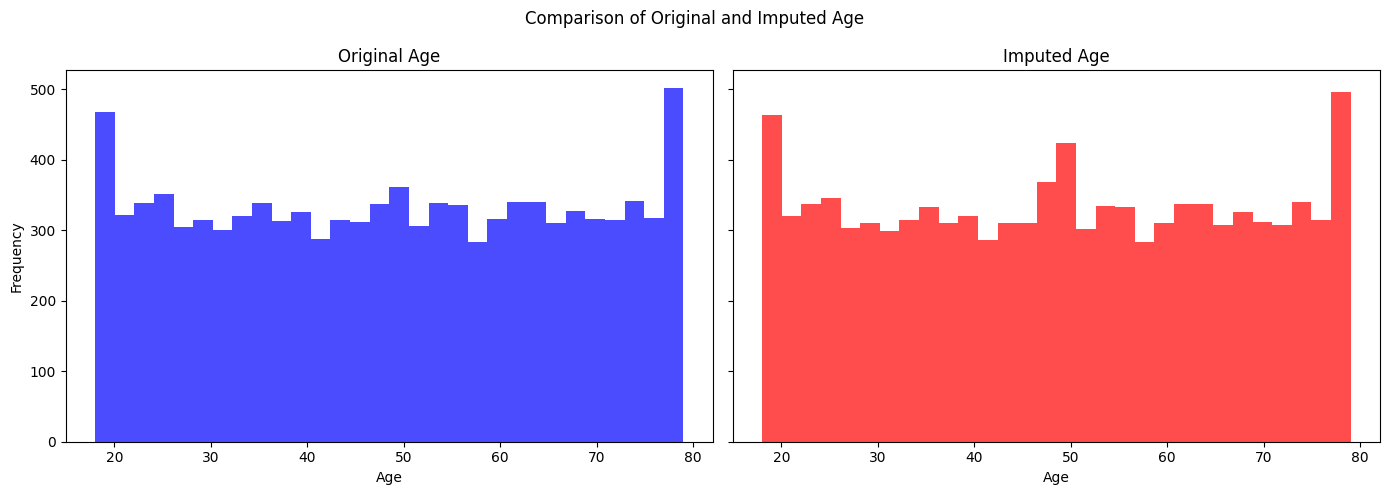

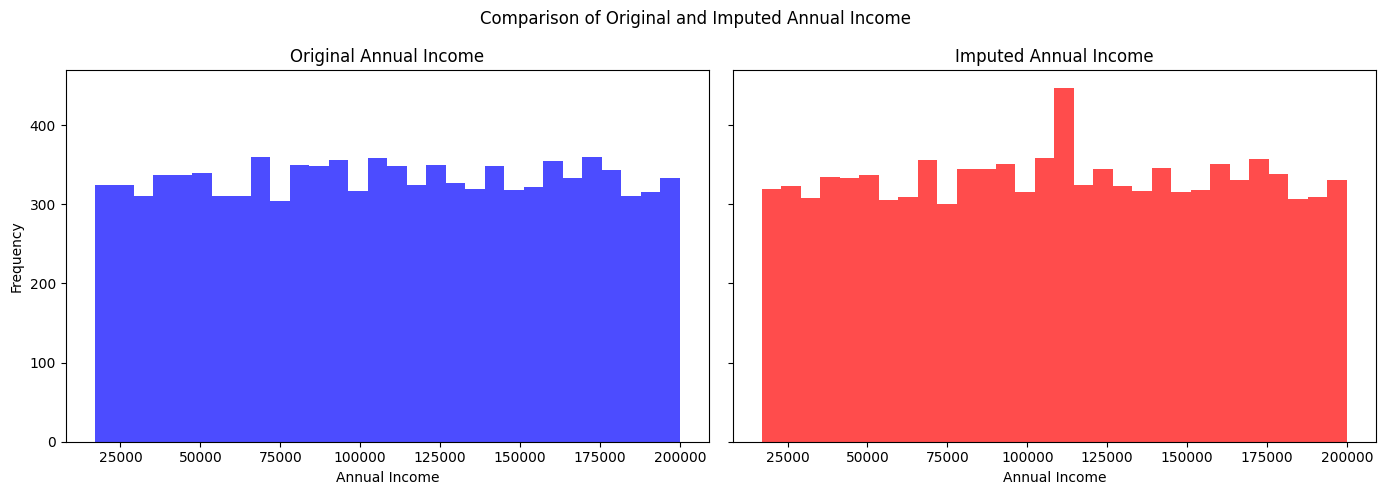

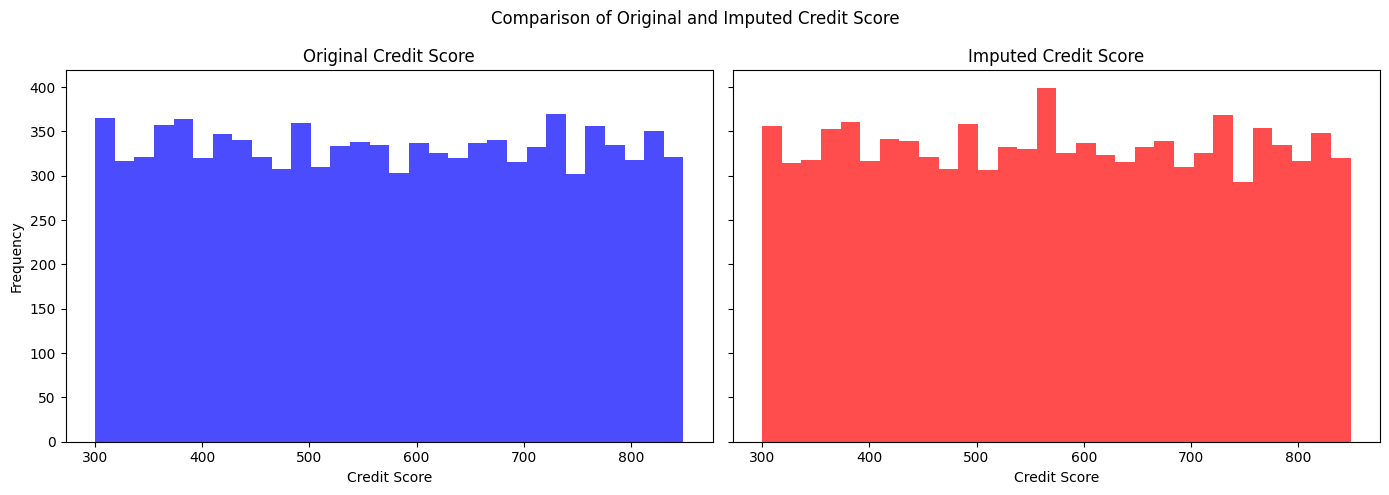

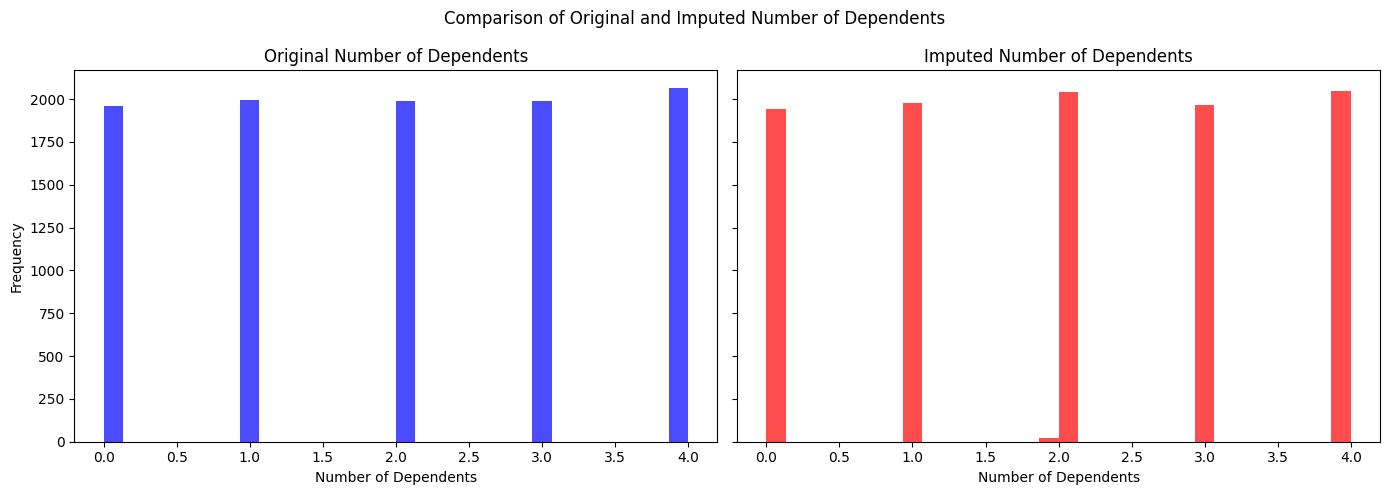

In [10]:

# Plot histograms for sample of features looking to make sure the imputer doesnt skew the distirbution
numerical_features = ['Age', 'Annual Income', 'Credit Score', 'Number of Dependents']

    
for feature in numerical_features:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    axes[0].hist(data[feature].dropna(), bins=30, alpha=0.7, color='blue')
    axes[0].set_title(f'Original {feature}')
    axes[0].set_xlabel(feature)
    axes[0].set_ylabel('Frequency')

    axes[1].hist(data_imputed_back_to_categorical[feature], bins=30, alpha=0.7, color='red')
    axes[1].set_title(f'Imputed {feature}')
    axes[1].set_xlabel(feature)

    plt.suptitle(f'Comparison of Original and Imputed {feature}')
    plt.tight_layout()
    plt.show()



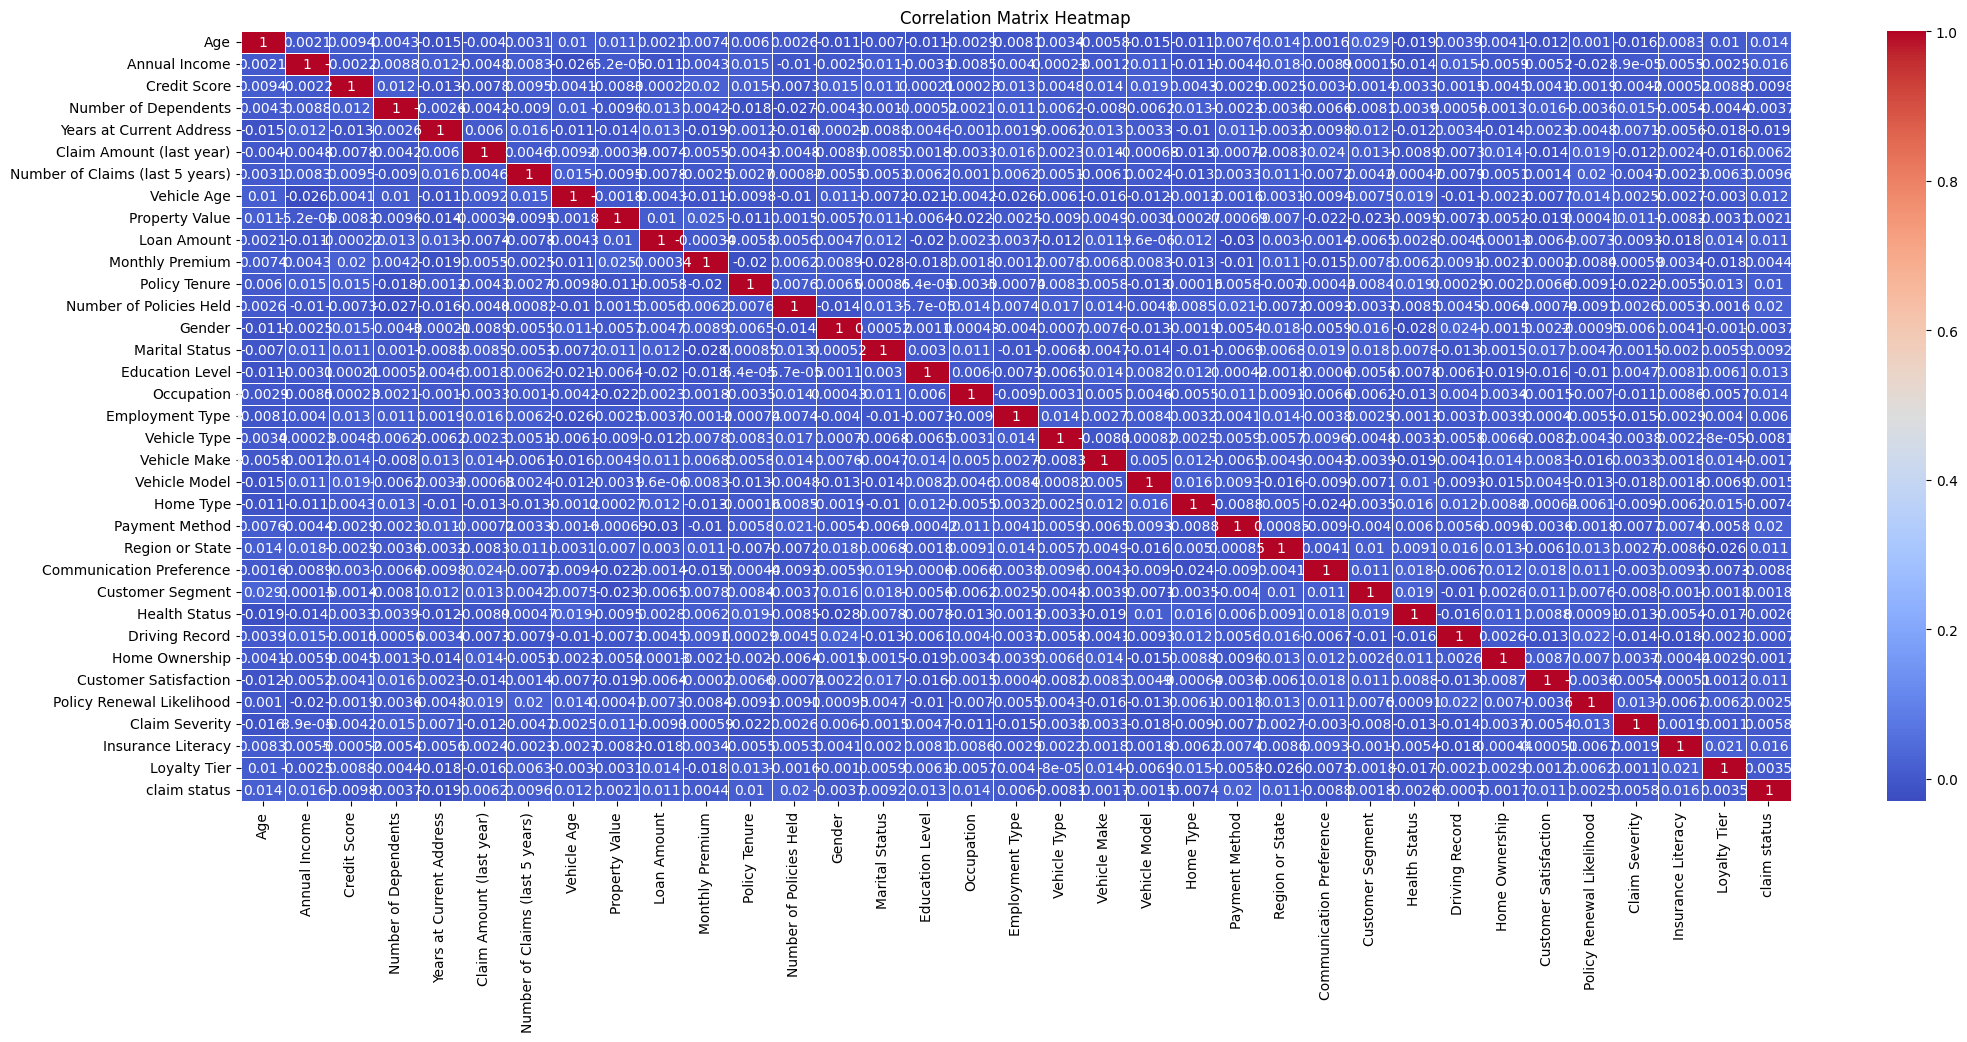

In [11]:
# correlation matrix
import seaborn as sns

correlation_matrix = data_imputed.corr()

# Plot heatmap of the correlation matrix
# correlation is going to be low as data is randomly generated
plt.figure(figsize=(25, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [12]:
data_imputed

,Age,Annual Income,Credit Score,Number of Dependents,Years at Current Address,Claim Amount (last year),Number of Claims (last 5 years),Vehicle Age,Property Value,Loan Amount,...,Customer Segment,Health Status,Driving Record,Home Ownership,Customer Satisfaction,Policy Renewal Likelihood,Claim Severity,Insurance Literacy,Loyalty Tier,claim status
0,53.0,134116.0,642.0,3.0,0.0,44189.0,4.0,2.0,418483.0,123919.0,...,1.000000,3.000000,0.0,1.0,5.0,1.0,0.000000,0.0,3.000000,1.0
1,32.0,80351.0,461.0,4.0,8.0,32989.0,8.0,10.0,930909.0,357208.0,...,1.000000,2.000000,2.0,0.0,2.0,1.0,1.000000,2.0,1.000000,1.0
2,65.0,175440.0,777.0,3.0,33.0,36874.0,9.0,10.0,266823.0,133234.0,...,0.000000,0.000000,0.0,1.0,5.0,1.0,1.000000,2.0,2.000000,1.0
3,79.0,120601.0,682.0,2.0,32.0,17849.0,6.0,12.0,384854.0,184732.0,...,0.535006,2.000000,2.0,2.0,2.0,0.0,2.000000,0.0,3.000000,0.0
4,56.0,28789.0,440.0,2.0,20.0,14600.0,6.0,17.0,998836.0,57861.0,...,1.000000,2.000000,2.0,2.0,3.0,2.0,0.000000,1.0,2.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,31.0,20454.0,537.0,1.0,35.0,35224.0,7.0,12.0,463865.0,53260.0,...,1.000000,4.000000,0.0,0.0,3.0,1.0,1.000000,2.0,3.000000,0.0
9996,38.0,143481.0,479.0,1.0,37.0,15045.0,7.0,5.0,616002.0,349599.0,...,1.000000,1.992223,2.0,0.0,1.0,2.0,2.000000,2.0,1.490372,0.0
9997,66.0,99387.0,650.0,3.0,19.0,28106.0,1.0,5.0,543184.0,4423.0,...,1.000000,0.000000,1.0,0.0,3.0,2.0,1.002735,2.0,0.000000,0.0
9998,47.0,151198.0,374.0,3.0,22.0,26065.0,6.0,1.0,853451.0,103172.0,...,1.000000,4.000000,1.0,2.0,5.0,1.0,2.000000,1.0,3.000000,0.0


### The business would like to understand how we could use this model to ensure that only 5% of the people they sell a policy to would claim on their policy.

- The model metric would be a False negative rate of 5%, I.e 5% of the time when the model predicts a claim status=0 the true value claim status=1

-NOTE; beacuse I'm using a tree based classifier there is no need to regularise the features in a Neural net/logistic reg I would regularise the input.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix


# Define target and features
target = 'claim status'
X = data_imputed.drop(columns=[target])
y = data_imputed[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Random Forest Accuracy: {accuracy:.2f}")


Random Forest Accuracy: 0.48


In [14]:
# False negative rate calculation
cm = confusion_matrix(y_test, y_pred)

TP = cm[1, 1]
FN = cm[1, 0]
FNR = FN / (FN + TP)
if FNR*100>5:
    print('model doesnt hit business requirement')
else:
    print('model good')

model doesnt hit business requirement


# model analysis, and understanding model inference e.g 

- feature importance 
- explainability

## in a real-world example here is the following approach i would take to refining and explain the model;
- look at feature importance (for a tree based model it is easy to do)
- for neural net/non -tree based models use permutation feature importance (randomly change values of feature to see what effect it has on the resulting prediction/ gives an indicator of which features are most important )
- shap explainer ( more detailed explainer with visualisations available)
- because the dataset is small and would be split into train/validation and test; use cross validation to utilise the full training set/ choose best hyper params and get a reliable metric score.

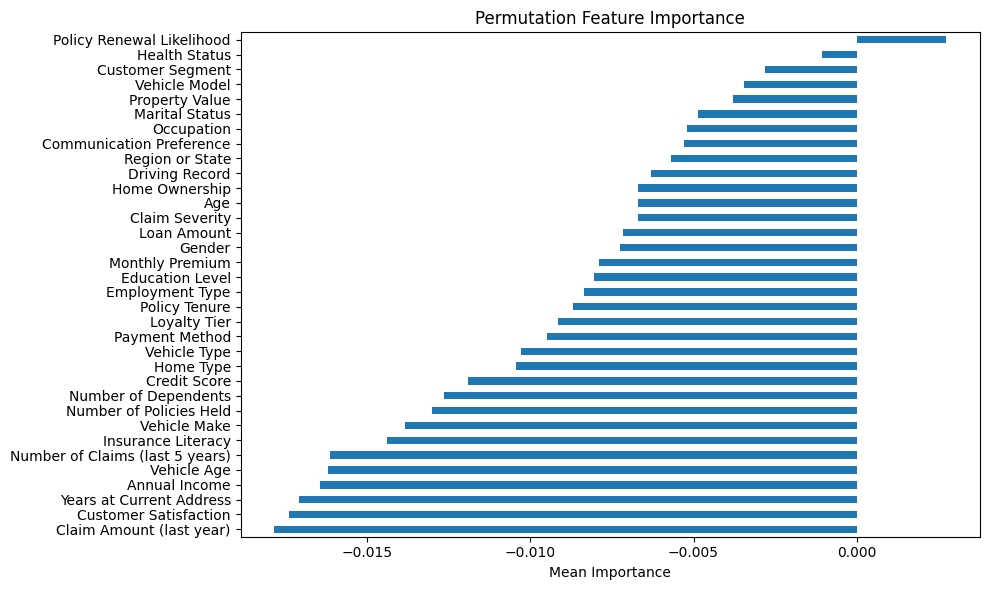

In [15]:
# Permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Map feature names
feature_names = X_test.columns
importances = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=False)

# Plot
importances.plot(kind='barh', figsize=(10, 6), title='Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.xlabel('Mean Importance')
plt.tight_layout()
plt.show()


# beacuse data is randomnly generated results arent good.


## Business wants the percentage probability when predicting a claim/no claim so they can change the risk profile as they see fit
 
 - The goal of this task is to predict the risk of offering an insurance policy to a potential customer

In [16]:

# probabilities of predicting each target allow for business to set the risk e.g >0.7
probabilities = model.predict_proba(X_test)
print(probabilities)

[[0.6  0.4 ]
 [0.57 0.43]
 [0.37 0.63]
 ...
 [0.56 0.44]
 [0.5  0.5 ]
 [0.48 0.52]]
